In [21]:
from MMI_solver import MMI, create_ridge,create_ridge2,create_taper,create_2D_sim,approximate_material
import gplugins.tidy3d.materials as mat
import numpy as np
import tidy3d as td
import matplotlib.pyplot as plt
import tidy3d.web as web


/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)
/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


[-7.         -6.98631476 -6.97262952 ...  6.97262952  6.98631476
  7.        ]


/Users/daniel/Desktop/gfp-cspdk.si220-main/scripts/TFM/Master-Thesis/.venv/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


  0%|          | 0/1000 [00:00<?, ?it/s]

ratio_out [0.99778693+0.j 0.00221307+0.j]
excess_loss (0.4810542135083513+0j)
Lpi_TE 62.22474162591845


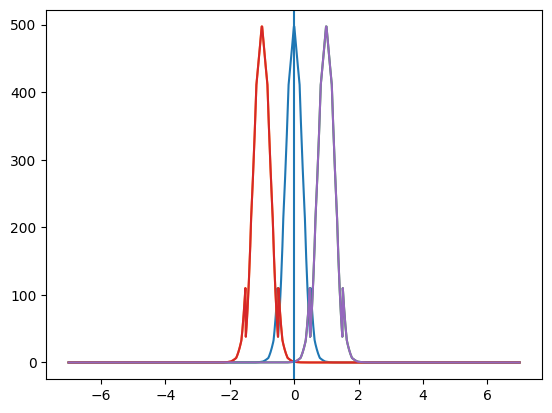

In [ ]:
Len_MMI = 59.92 #longitud del MMI
wvl = 1.55 #longitud de onda
mat_core = mat.sin(1.55) #material del core
mat_clad = mat.sio2(1.55) #material del clad
input_number = 2 #número de waveguides de entrada
output_number = 2 #número de waveguides de salida
input_positions = [-1/6,1/6] #posiciones de las waveguides de entrada
output_positions = [-1/6,1/6] #la maxima posicion es [-1/2,1/2]
wg_array_width=1.00 #anchura de la waveguide de entrada/salida
wg_array_thickness=0.8 #altura de la waveguide de entrada/salida, es igual que la del MMI
MMI_width=6.0 #anchura del MMI
MMI_num_modes=20#número de modos del MMI a calcular
slices=1024
gap1 = (input_positions[1]-input_positions[0]) * MMI_width - wg_array_width #distancia entre waveguides de entrada/salida

gap = (input_positions[1]-input_positions[0]) * MMI_width #distancia entre waveguides de entrada/salida
ratio_out ,excess_loss, L_v, intensidad_L, Lpi_TE, Lpi_TM = MMI(
    Len_MMI, #longitud del MMI
    wvl , #longitud de onda
    mat_core, #material del core
    mat_clad, #material del clad
    input_number, #número de waveguides de entrada
    output_number, #número de waveguides de salida
    input_positions, #posiciones de las waveguides de entrada
    output_positions, #la maxima posicion es [-1/2,1/2]
    wg_array_width, #anchura de la waveguide de entrada/salida
    wg_array_thickness, #altura de la waveguide de entrada/salida, es igual que la del MMI
    MMI_width, #anchura del MMI
    MMI_num_modes, #número de modos del MMI a calcular
    slices,
    gap1  #distancia entre waveguides de entrada/salida
)
print('ratio_out', ratio_out)
print('excess_loss', excess_loss)
print('Lpi_TE', Lpi_TE)


11:48:39 CEST WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

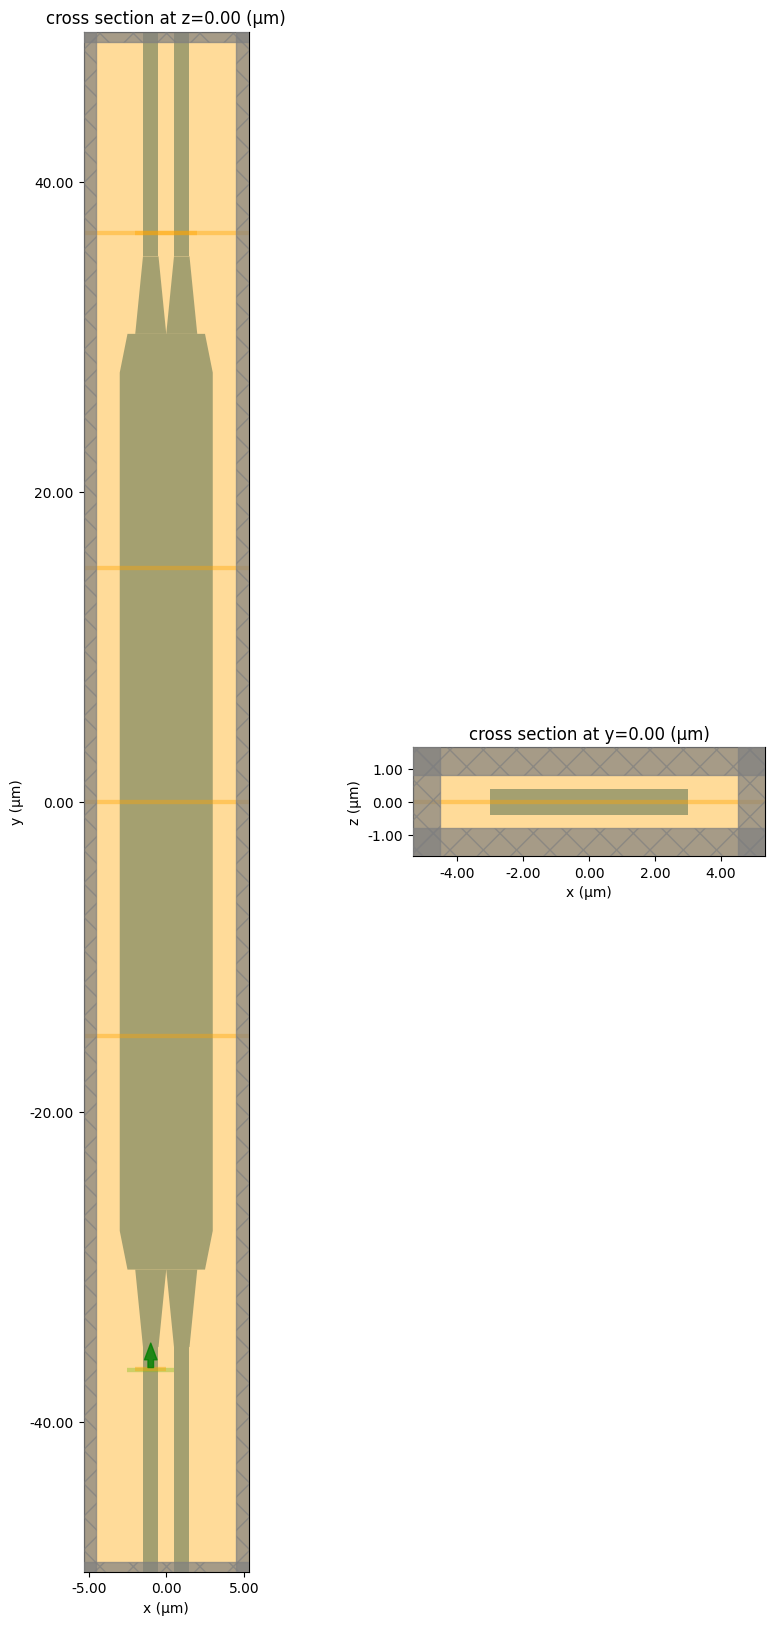

In [22]:
punto_exp = 96 #punto de la longitud del MMI a calcular, 0 es el mínimo y 99 es el máximo
#ahora empezaremos con la parte de tidy3d
Len_MMI_ = np.linspace(Lpi_TE/100,Lpi_TE,100) #longitud del MMI
Len_MMI = Len_MMI_[punto_exp] #longitud del MMI
#en primer lugar, definimos los materiales
#sin = td.material_library['cSi']['Li1993_293K'] #cristaline silicon
sin = td.material_library['SiN']['Horiba']  # 
sio2 = td.material_library['SiO2']['Horiba']
wvlenth = np.linspace(1.5,1.6,101)
freqs = td.C_0 / wvlenth
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))
freq0 = td.C_0 / 1.55

wvg_length = 1000
taper_length = 5.0

#creamos la estructura

MMI_body = td.Structure(
    geometry = create_ridge2(MMI_width,0,-Len_MMI/2,Len_MMI/2,-wg_array_thickness/2,wg_array_thickness/2,0,taper_length),
    medium = sin,)

Wg_in0 = td.Structure(
    geometry = create_ridge(wg_array_width,-gap/2,-(Len_MMI/2+taper_length+wvg_length),-(Len_MMI/2+taper_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_in0 = td.Structure(
    geometry = create_taper(MMI_width/3,-gap/2,-(Len_MMI/2+taper_length),-(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

Wg_in1 = td.Structure(
    geometry = create_ridge(wg_array_width,gap/2,-(Len_MMI/2+taper_length+wvg_length),-(Len_MMI/2+taper_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_in1 = td.Structure(
    geometry = create_taper(MMI_width/3,gap/2,-(Len_MMI/2+taper_length),-(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

Wg_out0 = td.Structure(
    geometry = create_ridge(wg_array_width,-gap/2,(Len_MMI/2+taper_length),(Len_MMI/2+taper_length+wvg_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_out0 = td.Structure(
    geometry = create_taper(MMI_width/3,-gap/2,(Len_MMI/2+taper_length),(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

Wg_out1 = td.Structure(
    geometry = create_ridge(wg_array_width,gap/2,(Len_MMI/2+taper_length),(Len_MMI/2+taper_length+wvg_length),-wg_array_thickness/2,wg_array_thickness/2,0),
    medium = sin,
)
Taper_out1 = td.Structure(
    geometry = create_taper(MMI_width/3,gap/2,(Len_MMI/2+taper_length),(Len_MMI/2),-wg_array_thickness/2,wg_array_thickness/2,0,wg_array_width),
    medium = sin,
)

####

#definimos los monitores y fuentes

mode_spec = td.ModeSpec(
    num_modes=2,
    target_neff=3,
    track_freq="central",
    precision= "double",
    group_index_step=True
)
mode_source = td.ModeSource(
    center = (-gap/2,-(Len_MMI/2+taper_length+1.5),0),
    size = (3 * wg_array_width,0 , 5*wg_array_thickness),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction = "+",
    mode_spec = mode_spec,
    mode_index=0,
    num_freqs=5,
)
field_monitor1 = td.FieldMonitor(
    center = (0,0,0), size = (td.inf,td.inf,0), freqs=[freq0], name = "field1"
)
field_monitor11 = td.FieldMonitor(
    center = (0,0,wg_array_thickness/2), size = (td.inf,td.inf,0), freqs=[freq0], name = "field11"
)
field_monitor2 = td.FieldMonitor(
    center = (0,0,0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field2"
)
field_monitor3 = td.FieldMonitor(
    center = (0,Len_MMI/4,0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field3"
)
field_monitor4 = td.FieldMonitor(
    center = (0,-Len_MMI/4,0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field4"
)

field_monitor5 = td.FieldMonitor(
    center = (0,(Len_MMI/2+taper_length+1.5),0), size = (td.inf,0,td.inf), freqs=[freq0], name = "field5"
)



flux_monitor0 = td.FluxMonitor(
    center = (-gap/2,-(Len_MMI/2+taper_length+1.4),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux0",
)


flux_monitor1 = td.FluxMonitor(
    center = (-gap/2,(Len_MMI/2+taper_length+1.5),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux1",
)

mode_monitor1 = td.ModeMonitor(
    center = (-gap/2, (Len_MMI/2+taper_length+3/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode1",

)

flux_monitor2 = td.FluxMonitor(
    center = (gap/2,(Len_MMI/2+taper_length+1.5),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux2",
)

mode_monitor2 = td.ModeMonitor( 
    center = (gap/2, (Len_MMI/2+taper_length+3/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode2",
)
flux_monitor00 = td.FluxMonitor(
    center = (-gap/2,-(Len_MMI/2),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux00",
)

mode_monitor00 = td.ModeMonitor(
    center = (-gap/2, -(Len_MMI/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode00",

)

flux_monitor11 = td.FluxMonitor(
    center = (-gap/2,(Len_MMI/2),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux11",
)

mode_monitor11 = td.ModeMonitor(
    center = (-gap/2, (Len_MMI/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode11",

)

flux_monitor22 = td.FluxMonitor(
    center = (gap/2,(Len_MMI/2),0),
    size = (2 * wg_array_width,0,5*wg_array_thickness),
    freqs = freqs,
    name = "flux22",
)

mode_monitor22 = td.ModeMonitor( 
    center = (gap/2, (Len_MMI/2),0),
    size = (2 * wg_array_width,0 , 5*wg_array_thickness),
    freqs= freqs,
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3),
    name = "mode22",
)

Lx = 1.5*MMI_width 
Ly= 1.5*(Len_MMI+taper_length) 
Lz = 2*wg_array_thickness
grid_spec = td.GridSpec.auto(min_steps_per_wvl=15,wavelength=1.55)
sim = td.Simulation(
    size = (Lx,Ly,Lz),
    grid_spec = grid_spec,
    run_time = 3e-12,
    boundary_spec= td.BoundarySpec.all_sides(boundary = td.PML()),
    medium=sio2,
    structures=(MMI_body,Wg_in0,Taper_in0,Wg_in1,Taper_in1,Wg_out0,Taper_out0,Wg_out1,Taper_out1),
    sources=[mode_source],
    monitors = [field_monitor1,field_monitor2,field_monitor3,field_monitor4,field_monitor5,flux_monitor0,flux_monitor1,flux_monitor2]#,mode_monitor1,mode_monitor2,flux_monitor00,flux_monitor11,flux_monitor22,mode_monitor00,mode_monitor11,mode_monitor22],
)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1 = sim.plot(z=0, ax=ax1)
ax2 = sim.plot(y=0, ax=ax2)
plt.show()

sim.plot_3d()


11:48:45 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-6c7544fe-84bf-46ef-9012-4942d9e0e368',              
              solver_id='mo-dfd3a35d-4dee-4cb1-8277-b471828c1c16'.

11:48:46 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:48:49 CEST Mode solver status: queued

11:48:51 CEST Mode solver status: running

11:48:55 CEST Mode solver status: success

Output()

11:48:58 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-b67d4819-8b3e-4bed-bc24-ba3a07f057ab',              
              solver_id='mo-42acd363-3c1b-463a-b9e5-81287b9b4805'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:49:02 CEST Mode solver status: queued

11:49:04 CEST Mode solver status: running

11:49:09 CEST Mode solver status: success

Output()

11:49:11 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-dc35e00c-9b19-413c-a33a-ed1ea5bd0700',              
              solver_id='mo-df1c8529-e757-436d-a0e8-c75f8ab4f439'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:49:15 CEST Mode solver status: queued

11:49:16 CEST Mode solver status: running

11:49:22 CEST Mode solver status: success

Output()

11:49:24 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

11:49:25 CEST Mode solver created with                                          
              task_id='fdve-5ddcec76-2112-46e5-a8c8-eaf416418a1c',              
              solver_id='mo-3133649e-dd5c-44c0-8c8e-b4ee781eda5c'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:49:29 CEST Mode solver status: queued

11:49:30 CEST Mode solver status: running

11:49:36 CEST Mode solver status: success

Output()

11:49:38 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-439d374c-aba3-48e1-906a-3ed48e52597c',              
              solver_id='mo-bdfb3819-ae9c-4b57-81a6-61222caf4ae2'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:49:42 CEST Mode solver status: queued

11:49:43 CEST Mode solver status: running

11:49:48 CEST Mode solver status: success

Output()

11:49:50 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

11:49:51 CEST Mode solver created with                                          
              task_id='fdve-ae39c20e-c737-42d6-9763-ee44f37f205a',              
              solver_id='mo-93008444-d3ce-4614-a4ec-2b74aaa17eee'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:49:54 CEST Mode solver status: queued

11:49:56 CEST Mode solver status: running

11:50:01 CEST Mode solver status: success

Output()

11:50:04 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-6fffe269-1f48-42f8-8534-3c88d7ba5909',              
              solver_id='mo-fe75e1ab-aed1-4835-9980-119aa0c9e2bf'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:50:08 CEST Mode solver status: queued

              Mode solver status: running

11:50:15 CEST Mode solver status: success

Output()

11:50:17 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-31684af8-6416-4997-9a75-799ecdacbe25',              
              solver_id='mo-620b74f0-cd42-4034-8a72-bef96538667d'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:50:21 CEST Mode solver status: queued

11:50:23 CEST Mode solver status: running

11:50:27 CEST Mode solver status: success

Output()

11:50:30 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-282bd2e1-5dab-40da-9e4a-6c523f24c550',              
              solver_id='mo-ae19a69c-3905-40c9-838b-9409fe2afe3e'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:50:33 CEST Mode solver status: queued

11:50:35 CEST Mode solver status: running

11:50:40 CEST Mode solver status: success

Output()

11:50:42 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-0f9aacb8-6f82-4abf-a4d4-a67ac242fdbb',              
              solver_id='mo-e505cc6c-f957-4907-ab1a-e0c4baa37616'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:50:46 CEST Mode solver status: queued

11:50:48 CEST Mode solver status: running

11:50:53 CEST Mode solver status: success

Output()

11:50:56 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-1c5da304-d20f-4c03-a0b4-d6ba9eab59ad',              
              solver_id='mo-dd69f945-861d-40b1-aed4-2119cec58a84'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:50:59 CEST Mode solver status: queued

11:51:01 CEST Mode solver status: running

11:51:06 CEST Mode solver status: success

Output()

Output()

11:51:10 CEST WARNING: Did not finish enforcing passivity in dispersion fitter. 
              If the fit is not good enough, consider increasing                
              'AdvancedFastFitterParam.passivity_num_iters'.                    

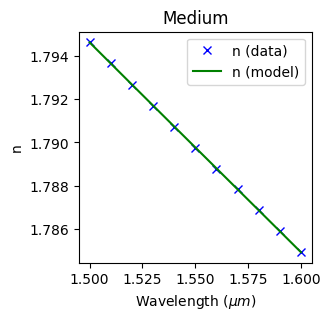

11:51:11 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-9f58288b-92a7-48b0-b4dd-9a1f64624943',              
              solver_id='mo-589e90ca-83d4-4d52-9d2c-7fc9462ceaa9'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:51:15 CEST Mode solver status: queued

              Mode solver status: running

11:51:22 CEST Mode solver status: success

Output()

11:51:24 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-b9b374f0-85ec-4140-b4e6-203a517c106e',              
              solver_id='mo-2bc9f332-e459-4907-a5d3-d3fc235d89f3'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:51:28 CEST Mode solver status: queued

11:51:29 CEST Mode solver status: running

11:51:34 CEST Mode solver status: success

Output()

11:51:37 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-99371238-a8f9-4556-b86a-b97cd7e1d894',              
              solver_id='mo-e2da4061-3cea-4af7-b3ea-f427fabd4ebd'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:51:41 CEST Mode solver status: queued

11:51:42 CEST Mode solver status: running

11:51:48 CEST Mode solver status: success

Output()

11:51:50 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-ff1b3587-d31e-4a1e-9cd0-fec4d1026183',              
              solver_id='mo-d5fda8e8-686c-4baa-be71-1818702e1e5d'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:51:54 CEST Mode solver status: queued

11:51:55 CEST Mode solver status: running

11:52:00 CEST Mode solver status: success

Output()

11:52:03 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-05fd296d-1410-4c22-bd45-ac8d45f487ee',              
              solver_id='mo-c3dab30b-d6db-45ac-99dd-ee04525071cb'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:52:08 CEST Mode solver status: queued

              Mode solver status: running

11:52:15 CEST Mode solver status: success

Output()

11:52:17 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-d9e88ae1-8970-4cf1-b565-4a3c6692a5a5',              
              solver_id='mo-d73b991a-ca2a-4172-8c67-b98aaa12890a'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:52:21 CEST Mode solver status: queued

11:52:22 CEST Mode solver status: running

11:52:28 CEST Mode solver status: success

Output()

11:52:30 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

11:52:31 CEST Mode solver created with                                          
              task_id='fdve-cb5924c5-d837-499e-bc8b-42561c06dc3a',              
              solver_id='mo-fb7fec2d-5094-4aa7-9cf6-6de2b4dd4ef6'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:52:34 CEST Mode solver status: queued

11:52:36 CEST Mode solver status: running

11:52:41 CEST Mode solver status: success

Output()

11:52:44 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-3c9b916a-befe-4b0e-9e6f-7e4d5f1cb896',              
              solver_id='mo-60f321a2-b4d9-460e-8acc-fa7d3e68c4c2'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:52:48 CEST Mode solver status: queued

11:52:49 CEST Mode solver status: running

11:52:55 CEST Mode solver status: success

Output()

11:52:57 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-3b00a901-5089-47ff-917d-bee4473d86a5',              
              solver_id='mo-e1878a60-06dc-4fbb-9ecc-e6232024401f'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:53:01 CEST Mode solver status: queued

11:53:02 CEST Mode solver status: running

11:53:07 CEST Mode solver status: success

Output()

11:53:10 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-3b82034d-3964-47db-b3eb-a2fb0df03f62',              
              solver_id='mo-b58f1d3d-3316-40e1-af4b-3eb19b38f21d'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:53:13 CEST Mode solver status: queued

11:53:15 CEST Mode solver status: running

11:53:22 CEST Mode solver status: success

Output()

11:53:24 CEST WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

              Mode solver created with                                          
              task_id='fdve-4e9a894b-4cf4-4e4f-973a-329b2d266da6',              
              solver_id='mo-801bfe33-6ba3-4aa5-ae42-1d25e9c6f361'.

              WARNING: 'simulation.structures[1]' is outside of the simulation  
              domain.                                                           

              WARNING: Suppressed 3 WARNING messages.                           

              WARNING: Structure at 'structures[2]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 3 WARNING messages.                           

Output()

Output()

11:53:28 CEST Mode solver status: queued

11:53:29 CEST Mode solver status: running

11:53:37 CEST Mode solver status: success

Output()

Output()

11:53:40 CEST WARNING: Did not finish enforcing passivity in dispersion fitter. 
              If the fit is not good enough, consider increasing                
              'AdvancedFastFitterParam.passivity_num_iters'.                    

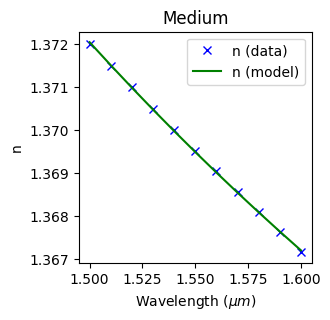

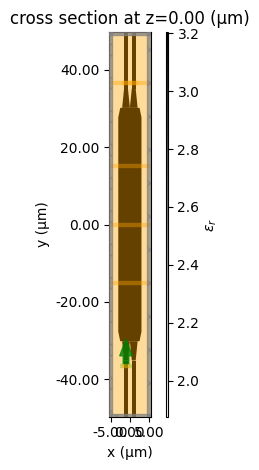

In [23]:
reference_point = (0,0)
waveguide_point = (0,0)
other_point = (0,(Len_MMI/2+taper_length+1.5))

spectrum = wvlenth[::10]

waveguide_medium = approximate_material(sim, waveguide_point, reference_point, spectrum)
background_medium = approximate_material(sim, other_point, reference_point, spectrum)

sim_2D = create_2D_sim(sim, [waveguide_medium, background_medium])
sim_2D.plot_eps(z=0,freq=freq0)
plt.show()

In [24]:
job = web.Job(simulation=sim_2D, task_name="MMI_2D", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)
print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

11:53:41 CEST Created task 'MMI_2D' with task_id                                
              'fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=435994;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=735314;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\taskId]8;;\]8;id=435994;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\=]8;;\]8;id=943680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\fdve]8;;\]8;id=435994;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\-75458611-7b]8;;\
              ]8;id=435994;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\37-408d-a1cf-cfdfa3ba3189']8;;\.

              Task folder: ]8;id=607953;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

11:53:43 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

11:53:44 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

The estimated maximum cost is 0.025 Flex Credits.


In [25]:
sim_data = job.run(path="data/MMI_2D.hdf5")


11:53:50 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

11:54:01 CEST starting up solver

              running solver

Output()

11:54:05 CEST early shutoff detected at 40%, exiting.

              status = postprocess

Output()

11:54:07 CEST status = success

11:54:09 CEST View simulation result at                                         
              ]8;id=819992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=315237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\taskId]8;;\]8;id=819992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\=]8;;\]8;id=92969;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\fdve]8;;\]8;id=819992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\-75458611-7b]8;;\
              ]8;id=819992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75458611-7b37-408d-a1cf-cfdfa3ba3189\37-408d-a1cf-cfdfa3ba3189']8;;\.

Output()

11:54:13 CEST loading simulation from data/MMI_2D.hdf5

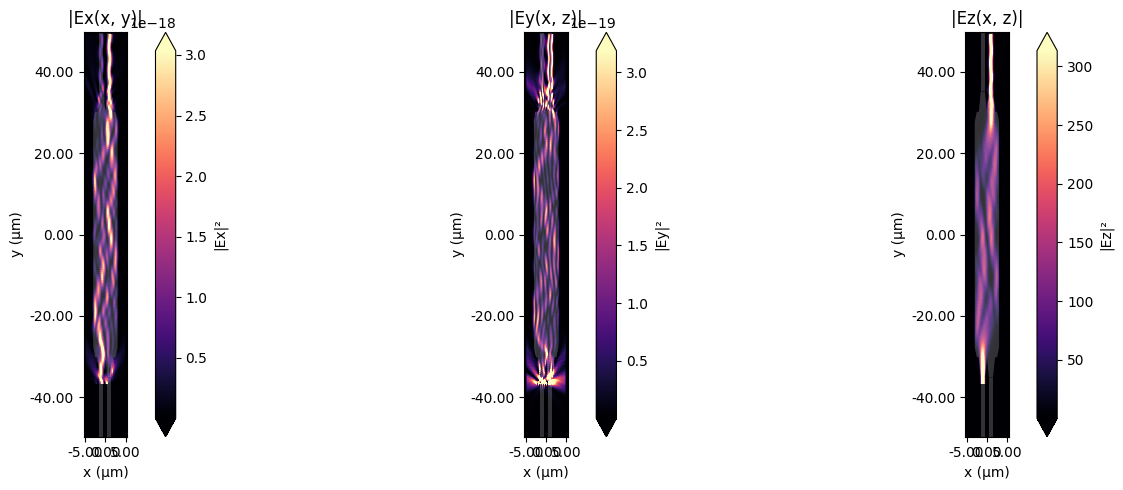

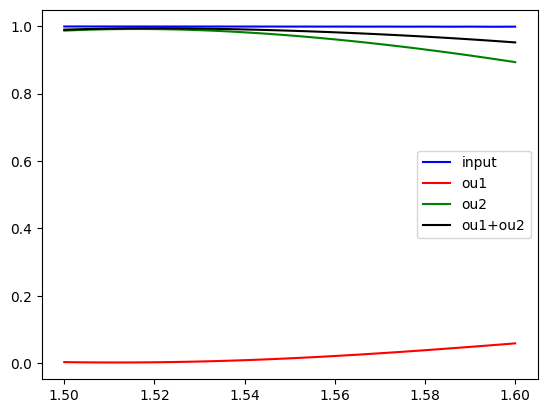

In [26]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 5))
sim_data.plot_field("field1", "Ex",val="abs^2", f=freq0, ax=ax1)
sim_data.plot_field("field1", "Ey",val="abs^2", f=freq0, ax=ax2)
sim_data.plot_field("field1", "Ez",val="abs^2", f=freq0, ax=ax3)
ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, z)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, z)|")
ax3.set_aspect("equal")
plt.show()

plt.figure()
#m0 = sim_data["mode00"].amps.sel(mode_index=0, direction="+").abs
#sim_data["mode1"].amps.sel(mode_index=0, direction="+").abs.plot(x="f")
#sim_data["mode2"].amps.sel(mode_index=0, direction="+").abs.plot(x="f")

#m1 = sim_data["mode1"].amps.sel(mode_index=0, direction="+").abs
#m2 = sim_data["mode2"].amps.sel(mode_index=0, direction="+").abs

#m11 = sim_data["mode11"].amps.sel(mode_index=0, direction="+").abs
#m22 = sim_data["mode22"].amps.sel(mode_index=0, direction="+").abs

T0_2d = sim_data["flux0"].flux
T1_2d = sim_data["flux1"].flux
T2_2d = sim_data["flux2"].flux


plt.plot(wvlenth, T0_2d, label="input",c = 'b')

plt.plot(wvlenth, T1_2d, label="ou1", c = 'r')
plt.plot(wvlenth, T2_2d, label="ou2", c = 'g')
plt.plot(wvlenth, T1_2d+T2_2d, label="ou1+ou2", c = 'k')
plt.legend()

#plt.plot(wvlenth, m1**2+m2**2, label="input", c = 'r')


plt.show()

In [27]:
job = web.Job(simulation=sim, task_name="MMI_2x2", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)
print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

11:55:37 CEST Created task 'MMI_2x2' with task_id                               
              'fdve-7f883d77-669f-4b92-b3f6-051acdf1e132' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=499634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=237449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\taskId]8;;\]8;id=499634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\=]8;;\]8;id=375412;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\fdve]8;;\]8;id=499634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\-7f883d77-66]8;;\
              ]8;id=499634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\9f-4b92-b3f6-051acdf1e132']8;;\.

              Task folder: ]8;id=52610;https://tidy3d.simulation.cloud/folders/folder-5c75483f-1275-4f77-a993-644506ee1773\'default']8;;\.

Output()

11:55:39 CEST Maximum FlexCredit cost: 0.286. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

11:55:40 CEST Maximum FlexCredit cost: 0.286. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

The estimated maximum cost is 0.286 Flex Credits.


In [28]:
sim_data = job.run(path="data/MMI_2x2.hdf5")

11:55:49 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

11:56:03 CEST status = preprocess

11:56:07 CEST starting up solver

              running solver

Output()

11:56:20 CEST early shutoff detected at 40%, exiting.

              status = postprocess

Output()

11:56:23 CEST status = success

11:56:25 CEST View simulation result at                                         
              ]8;id=101851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=897305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\taskId]8;;\]8;id=101851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\=]8;;\]8;id=245875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\fdve]8;;\]8;id=101851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\-7f883d77-66]8;;\
              ]8;id=101851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f883d77-669f-4b92-b3f6-051acdf1e132\9f-4b92-b3f6-051acdf1e132']8;;\.

Output()

11:56:29 CEST loading simulation from data/MMI_2x2.hdf5

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side z-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

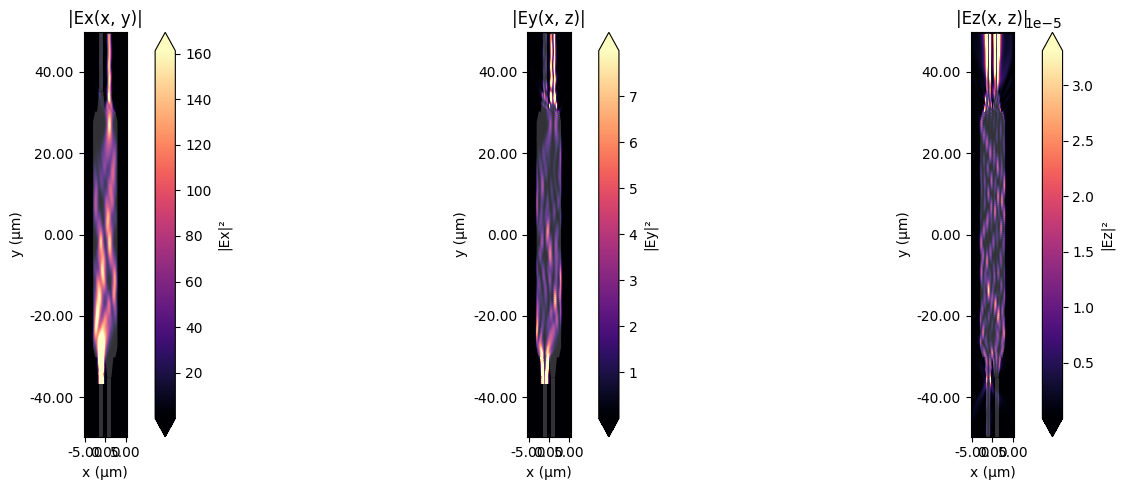

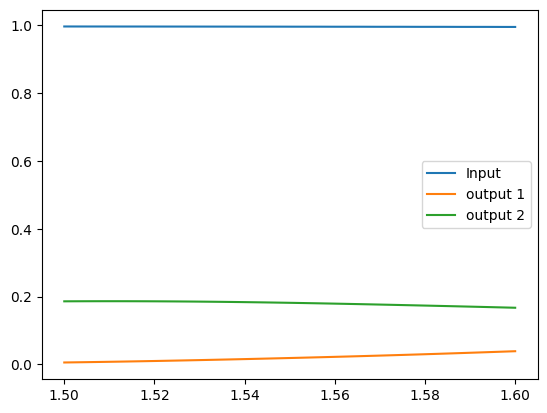

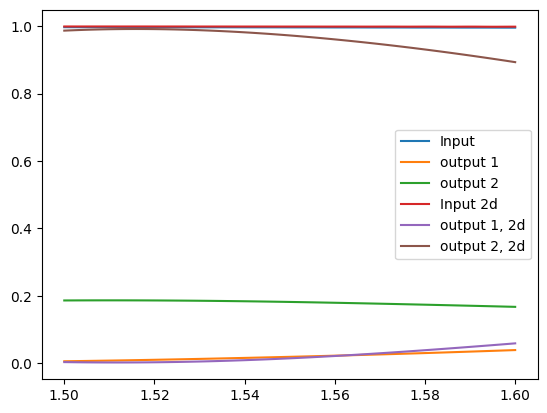

Text(467.6191219802256, 0.5, 'Excess loss (dB)')

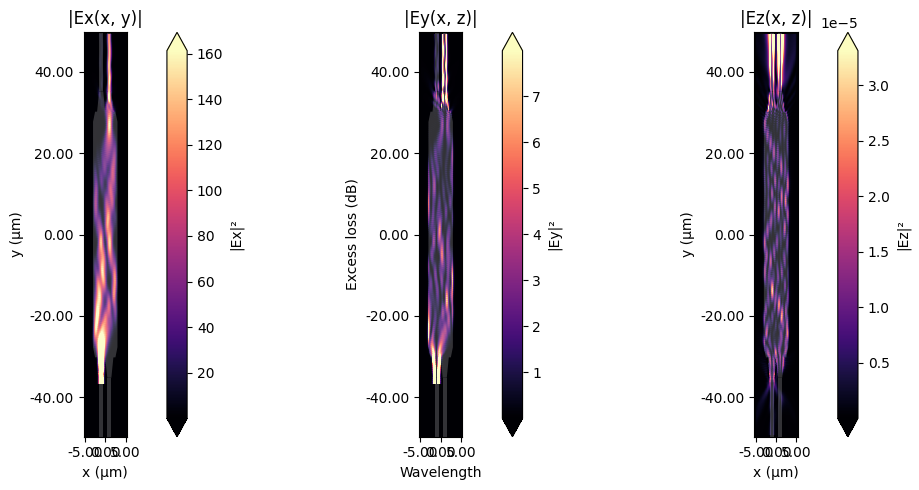

In [31]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 5))
sim_data.plot_field("field1", "Ex",val="abs^2", f=freq0, ax=ax1)
sim_data.plot_field("field1", "Ey",val="abs^2", f=freq0, ax=ax2)
sim_data.plot_field("field1", "Ez",val="abs^2", f=freq0, ax=ax3)
ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, z)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, z)|")
ax3.set_aspect("equal")
plt.show()

#m0 = sim_data["mode00"].amps.sel(mode_index=0, direction="+").abs
#m1 = sim_data["mode1"].amps.sel(mode_index=0, direction="+").abs
#m2 = sim_data["mode2"].amps.sel(mode_index=0, direction="+").abs

#m11 = sim_data["mode11"].amps.sel(mode_index=0, direction="+").abs   
#m22 = sim_data["mode22"].amps.sel(mode_index=0, direction="+").abs
ldas = wvlenth * 1e6  # Convert to nm

T0 = sim_data["flux0"].flux
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.plot(wvlenth, T0, label="Input")
plt.plot(wvlenth, T1, label="output 1")
plt.plot(wvlenth, T2, label="output 2")

plt.legend()
plt.show()

plt.plot(wvlenth, T0, label="Input")
plt.plot(wvlenth, T1, label="output 1")
plt.plot(wvlenth, T2, label="output 2")

plt.plot(wvlenth, T0_2d, label="Input 2d")
plt.plot(wvlenth, T1_2d, label="output 1, 2d")
plt.plot(wvlenth, T2_2d, label="output 2, 2d")
plt.legend()
plt.show()

plt.xlabel("Wavelength ")
plt.ylabel("Transmission to output waveguide")
plt.legend(("Output 0", "Output 1"))

plt.sca(ax2)
excess_loss = 10*np.log10((T1 + T2))
plt.plot(ldas, excess_loss)
plt.xlabel("Wavelength")
plt.ylabel("Excess loss (dB)")


